# Poboljšanje podataka

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier

from bartpy.sklearnmodel import SklearnModel
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

from scipy.stats import pearsonr
from sklearn import preprocessing
 


In [2]:
assessments = pd.read_csv("anonymisedData/assessments.csv")
courses = pd.read_csv("anonymisedData/courses.csv")
studentAssessment = pd.read_csv("anonymisedData/studentAssessment.csv")
studentInfo = pd.read_csv("anonymisedData/studentInfo.csv")
studentRegistration = pd.read_csv("anonymisedData/studentRegistration.csv")
studentVle = pd.read_csv("anonymisedData/studentVle.csv")
#vle = pd.read_csv("anonymisedData/vle.csv")

### Nedostajuće vrijednosti

Mijenjamo one značajke od interesa

In [6]:
studentAssessment.isna().sum()

id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64

In [10]:
null_scores = studentAssessment['score'].isnull()

mean_score = studentAssessment.loc[~null_scores, 'score'].mean()

studentAssessment.loc[null_scores, 'score'] = mean_score

studentAssessment.isna().sum()

id_assessment     0
id_student        0
date_submitted    0
is_banked         0
score             0
dtype: int64

In [7]:
studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [11]:
null_date = studentRegistration['date_registration'].isnull()

mean_date = studentRegistration.loc[~null_scores, 'date_registration'].mean()

studentRegistration.loc[null_date, 'date_registration'] = mean_date

studentRegistration.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration          0
date_unregistration    22521
dtype: int64

In [12]:
columns_studentInfo = ['id_student','gender', 'age_band', 'highest_education', 'final_result']
columns_studentAssessment = ['id_student','score']
columns_studentRegistration = ['id_student','date_registration']
columns_studentVle = [ 'id_student','sum_click']

merged_table_2 = pd.merge(studentInfo[columns_studentInfo],
                        studentAssessment[columns_studentAssessment],
                        on='id_student',
                        how='inner')
merged_table_2 = pd.merge(merged_table_2,
                        studentRegistration[columns_studentRegistration],
                        on='id_student',
                        how='inner')

studentVle_sum = studentVle.groupby('id_student')['sum_click'].sum().reset_index()
merged_table_2 = pd.merge(merged_table_2,
                        studentVle_sum[columns_studentVle],
                        on='id_student',
                        how='inner')

merged_table_2.dropna(inplace=True)
merged_table_2.drop('id_student',axis=1)

df = pd.DataFrame(merged_table_2)
#df.to_csv('merged_table_2.csv',index=False)


#uzet ću prvih 10 000 redaka
#merged_table_2 = df.sample(n=10000, random_state=42)
#merged_table_2.to_csv('merged_table_2.csv',index=False)


Withdrawn = {}
Fail = {}
Pass = {}
Distinction = {}

MODELS


In [15]:
def decision_tree(value,dataDT):
    X = df[['gender',	'age_band',	'highest_education',	'score'	,'date_registration',	'sum_click']]

    #df['final_result'] = label_encoder.fit_transform(df['final_result']) 
    df['binary_target'] = (df['final_result'] == value).astype(int)

    y = df['binary_target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predictions, average='weighted')
    dataDT.append(precision)
    dataDT.append(recall)
    dataDT.append(f1_score)
    dataDT.append(accuracy)
    if value == 'Withdrawn':
        Withdrawn['precisionDT'] = precision
        Withdrawn['recallDT'] = recall
        Withdrawn['f1_scoreDT'] = f1_score
        Withdrawn['accuracyDT'] = accuracy
    if value == 'Fail':
        Fail['precisionDT'] = precision
        Fail['recallDT'] = recall
        Fail['f1_scoreDT'] = f1_score
        Fail['accuracyDT'] = accuracy
    if value == 'Pass':
        Pass['precisionDT'] = precision
        Pass['recallDT'] = recall
        Pass['f1_scoreDT'] = f1_score
        Pass['accuracyDT'] = accuracy
    if value == 'Distinction':
        Distinction['precisionDT'] = precision
        Distinction['recallDT'] = recall
        Distinction['f1_scoreDT'] = f1_score
        Distinction['accuracyDT'] = accuracy
    
    #ROC
    probabilities = clf.predict_proba(X_test)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    roc_auc = roc_auc_score(y_test, probabilities)
    
    dataDT.append(fpr)
    dataDT.append(tpr)
    dataDT.append(thresholds)
    dataDT.append(roc_auc)
    


    if value == 'Pass':
        return confusion_matrix(y_test, predictions)
    del X_train, X_test, y_train, y_test, clf

In [19]:

cm_decision_tree = []
df = pd.DataFrame(merged_table_2)

label_encoder = preprocessing.LabelEncoder() 
df['gender'] = label_encoder.fit_transform(df['gender']) 
df['age_band'] = label_encoder.fit_transform(df['age_band']) 
df['highest_education'] = label_encoder.fit_transform(df['highest_education']) 


values =['Withdrawn','Fail','Pass','Distinction']
dataDT = []
for i in values:
    
    
    if i == 'Pass':
       cm_decision_tree = decision_tree(i,dataDT)
    else:
        decision_tree(i,dataDT)
    

del df    


In [17]:
def random_forest(dataRF, value):
    X = df[['gender',	'age_band',	'highest_education',	'score'	,'date_registration',	'sum_click']]

    #df['final_result'] = label_encoder.fit_transform(df['final_result']) 
    df['binary_target'] = (df['final_result'] == value).astype(int)

    y = df['binary_target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  

    clf.fit(X_train, y_train)

    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predictions, average='weighted')
    dataRF.append(precision)
    dataRF.append(recall)
    dataRF.append(f1_score)
    dataRF.append(accuracy)
    
    if value == 'Withdrawn':
        Withdrawn['precisionRF'] = precision
        Withdrawn['recallRF'] = recall
        Withdrawn['f1_scoreRF'] = f1_score
        Withdrawn['accuracyRF'] = accuracy
    if value == 'Fail':
        Fail['precisionRF'] = precision
        Fail['recallRF'] = recall
        Fail['f1_scoreRF'] = f1_score
        Fail['accuracyRF'] = accuracy
    if value == 'Pass':
        Pass['precisionRF'] = precision
        Pass['recallRF'] = recall
        Pass['f1_scoreRF'] = f1_score
        Pass['accuracyRF'] = accuracy
    if value == 'Distinction':
        Distinction['precisionRF'] = precision
        Distinction['recallRF'] = recall
        Distinction['f1_scoreRF'] = f1_score
        Distinction['accuracyRF'] = accuracy
    
    #ROC
    probabilities = clf.predict_proba(X_test)[:, 1]  

    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    roc_auc = roc_auc_score(y_test, probabilities)
    
    dataRF.append(fpr)
    dataRF.append(tpr)
    dataRF.append(thresholds)
    dataRF.append(roc_auc)
    

    
    
    if value == 'Pass':
        return confusion_matrix(y_test, predictions)

In [20]:

df = pd.DataFrame(merged_table_2)
cm_random_forest = []
label_encoder = preprocessing.LabelEncoder() 
df['gender'] = label_encoder.fit_transform(df['gender']) 
df['age_band'] = label_encoder.fit_transform(df['age_band']) 
df['highest_education'] = label_encoder.fit_transform(df['highest_education']) 

data_random_forest = {}


values =['Withdrawn','Fail','Pass','Distinction']
dataRF = []
for i in values:
    
    if i == 'Pass':
       cm_random_forest = random_forest(dataRF,i)
    else:
        random_forest(dataRF,i)
del df


In [34]:
table3_list = [
    ['','Metric', 'Decision Tree' ,'Random Forest'],
    ['Withdrawn','Precision',Withdrawn['precisionDT'],Withdrawn['precisionRF']],
    ['Withdrawn','Recall',Withdrawn['recallDT'],Withdrawn['recallRF']],
    ['Withdrawn','F1',Withdrawn['f1_scoreDT'],Withdrawn['f1_scoreRF']],
    ['Withdrawn','Accuracy',Withdrawn['accuracyDT'],Withdrawn['accuracyRF']],
    
    ['Fail','Precision',Fail['precisionDT'],Fail['precisionRF']],
    ['Fail','Recall',Fail['recallDT'],Fail['recallRF']],
    ['Fail','F1',Fail['f1_scoreDT'],Fail['f1_scoreRF']],
    ['Fail','Accuracy',Fail['accuracyDT'],Fail['accuracyRF']],
    
    ['Pass','Precision',Pass['precisionDT'],Pass['precisionRF']],
    ['Pass','Recall',Pass['recallDT'],Pass['recallRF']],
    ['Pass','F1',Pass['f1_scoreDT'],Pass['f1_scoreRF']],
    ['Pass','Accuracy',Pass['accuracyDT'],Pass['accuracyRF']],
    
    ['Distinction','Precision',Distinction['precisionDT'],Distinction['precisionRF']],
    ['Distinction','Recall',Distinction['recallDT'],Distinction['recallRF']],
    ['Distinction','F1',Distinction['f1_scoreDT'],Distinction['f1_scoreRF']],
    ['Distinction','Accuracy',Distinction['accuracyDT'],Distinction['accuracyRF']]
]

for i in range(0, len(table3_list)):
    for j in range(0, len(table3_list[i])):
        if type(table3_list[i][j]) != str:
            table3_list[i][j] = round(table3_list[i][j],2)

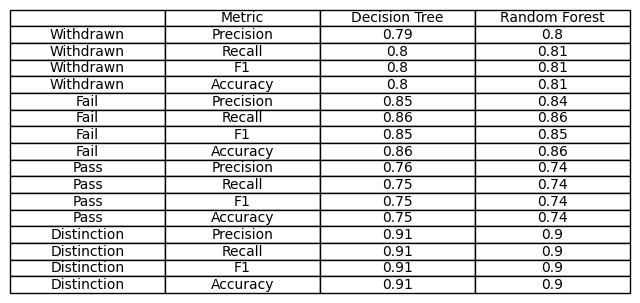

In [36]:
#ispis tablice
fig, ax = plt.subplots(figsize=(8, 3))

ax.axis('off')

table = ax.table(cellText=table3_list, loc='center', cellLoc='center', colLabels=None)

plt.show()

### Micanje outliera

In [40]:
studentVle = studentVle[~((studentVle['sum_click'] >= 3000) & (studentVle['sum_click'] <= 7000))]

In [44]:
columns_studentInfo = ['id_student','gender', 'age_band', 'highest_education', 'final_result']
columns_studentAssessment = ['id_student','score']
columns_studentRegistration = ['id_student','date_registration']
columns_studentVle = [ 'id_student','sum_click']

merged_table_2 = pd.merge(studentInfo[columns_studentInfo],
                        studentAssessment[columns_studentAssessment],
                        on='id_student',
                        how='inner')
merged_table_2 = pd.merge(merged_table_2,
                        studentRegistration[columns_studentRegistration],
                        on='id_student',
                        how='inner')

studentVle_sum = studentVle.groupby('id_student')['sum_click'].sum().reset_index()
merged_table_2 = pd.merge(merged_table_2,
                        studentVle_sum[columns_studentVle],
                        on='id_student',
                        how='inner')

merged_table_2.dropna(inplace=True)
merged_table_2.drop('id_student',axis=1)

df = pd.DataFrame(merged_table_2)
#df.to_csv('merged_table_2.csv',index=False)


#uzet ću prvih 10 000 redaka
#merged_table_2 = df.sample(n=10000, random_state=42)
#merged_table_2.to_csv('merged_table_2.csv',index=False)


Withdrawn = {}
Fail = {}
Pass = {}
Distinction = {}

In [45]:

cm_decision_tree = []
df = pd.DataFrame(merged_table_2)

label_encoder = preprocessing.LabelEncoder() 
df['gender'] = label_encoder.fit_transform(df['gender']) 
df['age_band'] = label_encoder.fit_transform(df['age_band']) 
df['highest_education'] = label_encoder.fit_transform(df['highest_education']) 


values =['Withdrawn','Fail','Pass','Distinction']
dataDT = []
for i in values:
    
    
    if i == 'Pass':
       cm_decision_tree = decision_tree(i,dataDT)
    else:
        decision_tree(i,dataDT)
    

del df    


In [46]:

df = pd.DataFrame(merged_table_2)
cm_random_forest = []
label_encoder = preprocessing.LabelEncoder() 
df['gender'] = label_encoder.fit_transform(df['gender']) 
df['age_band'] = label_encoder.fit_transform(df['age_band']) 
df['highest_education'] = label_encoder.fit_transform(df['highest_education']) 

data_random_forest = {}


values =['Withdrawn','Fail','Pass','Distinction']
dataRF = []
for i in values:
    
    if i == 'Pass':
       cm_random_forest = random_forest(dataRF,i)
    else:
        random_forest(dataRF,i)
del df


In [47]:
table3_list = [
    ['','Metric', 'Decision Tree' ,'Random Forest'],
    ['Withdrawn','Precision',Withdrawn['precisionDT'],Withdrawn['precisionRF']],
    ['Withdrawn','Recall',Withdrawn['recallDT'],Withdrawn['recallRF']],
    ['Withdrawn','F1',Withdrawn['f1_scoreDT'],Withdrawn['f1_scoreRF']],
    ['Withdrawn','Accuracy',Withdrawn['accuracyDT'],Withdrawn['accuracyRF']],
    
    ['Fail','Precision',Fail['precisionDT'],Fail['precisionRF']],
    ['Fail','Recall',Fail['recallDT'],Fail['recallRF']],
    ['Fail','F1',Fail['f1_scoreDT'],Fail['f1_scoreRF']],
    ['Fail','Accuracy',Fail['accuracyDT'],Fail['accuracyRF']],
    
    ['Pass','Precision',Pass['precisionDT'],Pass['precisionRF']],
    ['Pass','Recall',Pass['recallDT'],Pass['recallRF']],
    ['Pass','F1',Pass['f1_scoreDT'],Pass['f1_scoreRF']],
    ['Pass','Accuracy',Pass['accuracyDT'],Pass['accuracyRF']],
    
    ['Distinction','Precision',Distinction['precisionDT'],Distinction['precisionRF']],
    ['Distinction','Recall',Distinction['recallDT'],Distinction['recallRF']],
    ['Distinction','F1',Distinction['f1_scoreDT'],Distinction['f1_scoreRF']],
    ['Distinction','Accuracy',Distinction['accuracyDT'],Distinction['accuracyRF']]
]

for i in range(0, len(table3_list)):
    for j in range(0, len(table3_list[i])):
        if type(table3_list[i][j]) != str:
            table3_list[i][j] = round(table3_list[i][j],2)

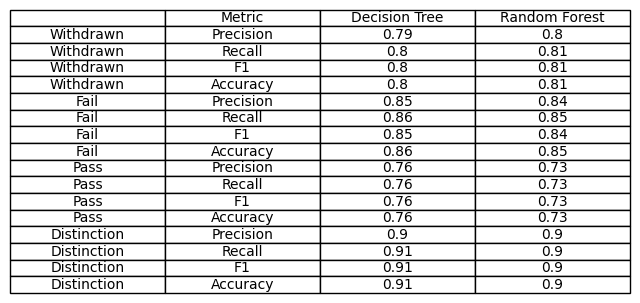

In [48]:
#ispis tablice
fig, ax = plt.subplots(figsize=(8, 3))

ax.axis('off')

table = ax.table(cellText=table3_list, loc='center', cellLoc='center', colLabels=None)

plt.show()

### Skaliranje, normaliziranje podataka

### Inženjerstvo značajki

Create Relevant Features: Consider creating new features that might capture important information or interactions between existing features.

### Hyperparameter Tuning:

For decision trees and random forests, tune hyperparameters such as the tree depth, minimum samples per leaf, and number of trees.
For BART, explore the hyperparameters specific to the model, such as the number of trees, tree depth, and learning rate.